In [1]:
import csv
from collections import defaultdict
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
from matplotlib import font_manager

Import data

In [2]:
columns = defaultdict(list) # each value in each column is appended to a list
path = './data/'
smfc_files = ['imwut_v1_1_rocketlogger.csv', 'imwut_v1_2_rocketlogger.csv', 'imwut_v1_3_rocketlogger.csv',
         'imwut_v3.1_1_rocketlogger.csv', 'imwut_v3.1_2_rocketlogger.csv', 'imwut_v3.1_3_rocketlogger.csv']
teros_files = ['imwut_v1_1_teros12.csv', 'imwut_v1_2_teros12.csv', 'imwut_v1_3_teros12.csv',
               'imwut_v3.1_1_teros12.csv', 'imwut_v3.1_2_teros12.csv', 'imwut_v3.1_3_teros12.csv']
smfcs = [defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list)]
teros = [defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list)]

#import the RocketLogger data, teaders are ts, v, i
for i in range(len(smfc_files)):
    with open(path + smfc_files[i]) as f:
        reader = csv.DictReader(f) # read rows into a dictionary format
        for row in reader: # read a row as {column1: value1, column2: value2,...}
            for (k,v) in row.items(): # go over each column name and value 
                if v != '':
                    smfcs[i][k].append(v) # append the value into the appropriate list
                                    # based on column name k

#import the TEROS data, headers are ts, raw_vwc, vwc, temp, ec
for i in range(len(teros_files)):
    with open(path + teros_files[i]) as f:
        reader = csv.DictReader(f) # read rows into a dictionary format
        for row in reader: # read a row as {column1: value1, column2: value2,...}
            for (k,v) in row.items(): # go over each column name and value 
                if v != '':
                    teros[i][k].append(v) # append the value into the appropriate list
                                    # based on column name k

Now convert values into the correct units we want

In [3]:
#convert from scientific notation to number
for i in range(len(smfc_files)):
    start = float(smfcs[i]['ts'][0]) #first time stamp
    for j in range(len(smfcs[i]['v'])):
        #convert from scientific notation to number
        smfcs[i]['v'][j] = 1e3*float(smfcs[i]['v'][j]) #mV
        smfcs[i]['i'][j] = 1e6*float(smfcs[i]['i'][j]) #uA
        #convert unix seconds to day since the start
        #print(float(smfcs[i]['ts'][j]), float(smfcs[i]['ts'][0]), (float(smfcs[i]['ts'][j])-start)/(60*60*24))
        smfcs[i]['ts'][j] = (float(smfcs[i]['ts'][j].strip("\x00"))-start)/(60*60*24)
        #Add power column
        smfcs[i]['p'].append(1e-3*smfcs[i]['v'][j]*smfcs[i]['i'][j]) #uW

#also fix TEROS sensor time stamp to unit of days
for i in range(len(teros_files)):
    start = float(teros[i]['ts'][0]) #first time stamp
    for j in range(len(teros[i]['ts'])):
        teros[i]['ts'][j] = (float(teros[i]['ts'][j].strip("\x00"))-start)/(60*60*24)
        teros[i]['raw_vwc'][j] = float(teros[i]['raw_vwc'][j])
        teros[i]['vwc'][j] = float(teros[i]['vwc'][j])
        teros[i]['temp'][j] = float(teros[i]['temp'][j])
        teros[i]['ec'][j] = float(teros[i]['ec'][j])

Plot voltage, current, power

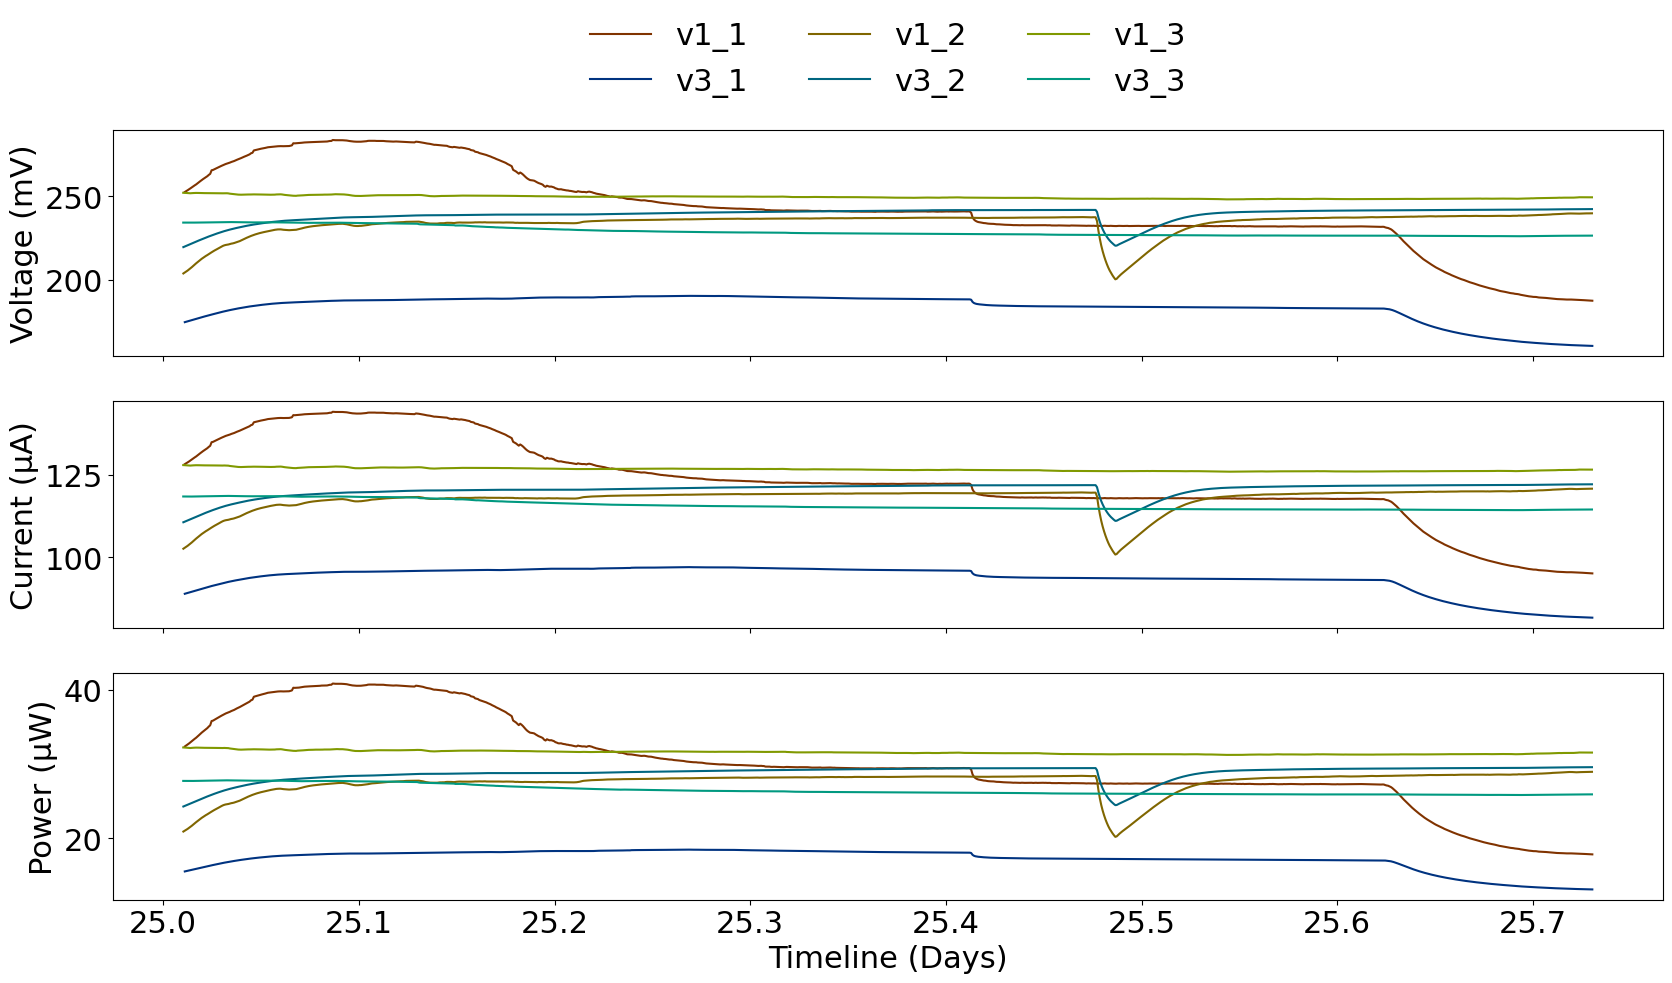

In [4]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams.update({'font.size': 22})
fig, axs = plt.subplots(3)
r = 1000
#voltage (mV)
axs[0].plot(smfcs[0]['ts'][-r:], smfcs[0]['v'][-r:], label="v1_1", color= (0.5,0.2,0))
axs[0].plot(smfcs[3]['ts'][-r:], smfcs[3]['v'][-r:], label="v3_1", color= (0,0.2,0.5))

axs[0].plot(smfcs[1]['ts'][-r:], smfcs[1]['v'][-r:], label="v1_2", color= (0.5,0.4,0))
axs[0].plot(smfcs[4]['ts'][-r:], smfcs[4]['v'][-r:], label="v3_2", color= (0,0.4,0.5))

axs[0].plot(smfcs[2]['ts'][-r:], smfcs[2]['v'][-r:], label="v1_3", color= (0.5,0.6,0))
axs[0].plot(smfcs[5]['ts'][-r:], smfcs[5]['v'][-r:], label="v3_3", color= (0,0.6,0.5))

#axs[0].set_ylim([0, 10])
axs[0].xaxis.set_tick_params(labelbottom=False) #get rid of x axis tick label

#current (uA)
axs[1].plot(smfcs[0]['ts'][-r:], smfcs[0]['i'][-r:], label="v1_1", color= (0.5,0.2,0))
axs[1].plot(smfcs[3]['ts'][-r:], smfcs[3]['i'][-r:], label="v3_1", color= (0,0.2,0.5))

axs[1].plot(smfcs[1]['ts'][-r:], smfcs[1]['i'][-r:], label="v1_2", color= (0.5,0.4,0))
axs[1].plot(smfcs[4]['ts'][-r:], smfcs[4]['i'][-r:], label="v3_2", color= (0,0.4,0.5))

axs[1].plot(smfcs[2]['ts'][-r:], smfcs[2]['i'][-r:], label="v1_3", color= (0.5,0.6,0))
axs[1].plot(smfcs[5]['ts'][-r:], smfcs[5]['i'][-r:], label="v3_3", color= (0,0.6,0.5))

axs[1].xaxis.set_tick_params(labelbottom=False)  #get rid of x axis tick label

#power (uW)
axs[2].plot(smfcs[0]['ts'][-r:], smfcs[0]['p'][-r:], label="v1_1", color= (0.5,0.2,0))
axs[2].plot(smfcs[3]['ts'][-r:], smfcs[3]['p'][-r:], label="v3_1", color= (0,0.2,0.5))

axs[2].plot(smfcs[1]['ts'][-r:], smfcs[1]['p'][-r:], label="v1_2", color= (0.5,0.4,0))
axs[2].plot(smfcs[4]['ts'][-r:], smfcs[4]['p'][-r:], label="v3_2", color= (0,0.4,0.5))

axs[2].plot(smfcs[2]['ts'][-r:], smfcs[2]['p'][-r:], label="v1_3", color= (0.5,0.6,0))
axs[2].plot(smfcs[5]['ts'][-r:], smfcs[5]['p'][-r:], label="v3_3", color= (0,0.6,0.5))

# for ax in axs.flat:
#     ax.set(xlabel='x-label', ylabel='y-label')
axs[0].set_ylabel('Voltage (mV)')
axs[1].set_ylabel('Current (µA)')
axs[2].set_ylabel('Power (µW)')
plt.xlabel('Timeline (Days)')

plt.legend(loc='upper center', bbox_to_anchor=(0.5,4),
          fancybox=True, ncol=3, frameon=False)
plt.show()

Now plot raw_vwc, vwc, temp, ec

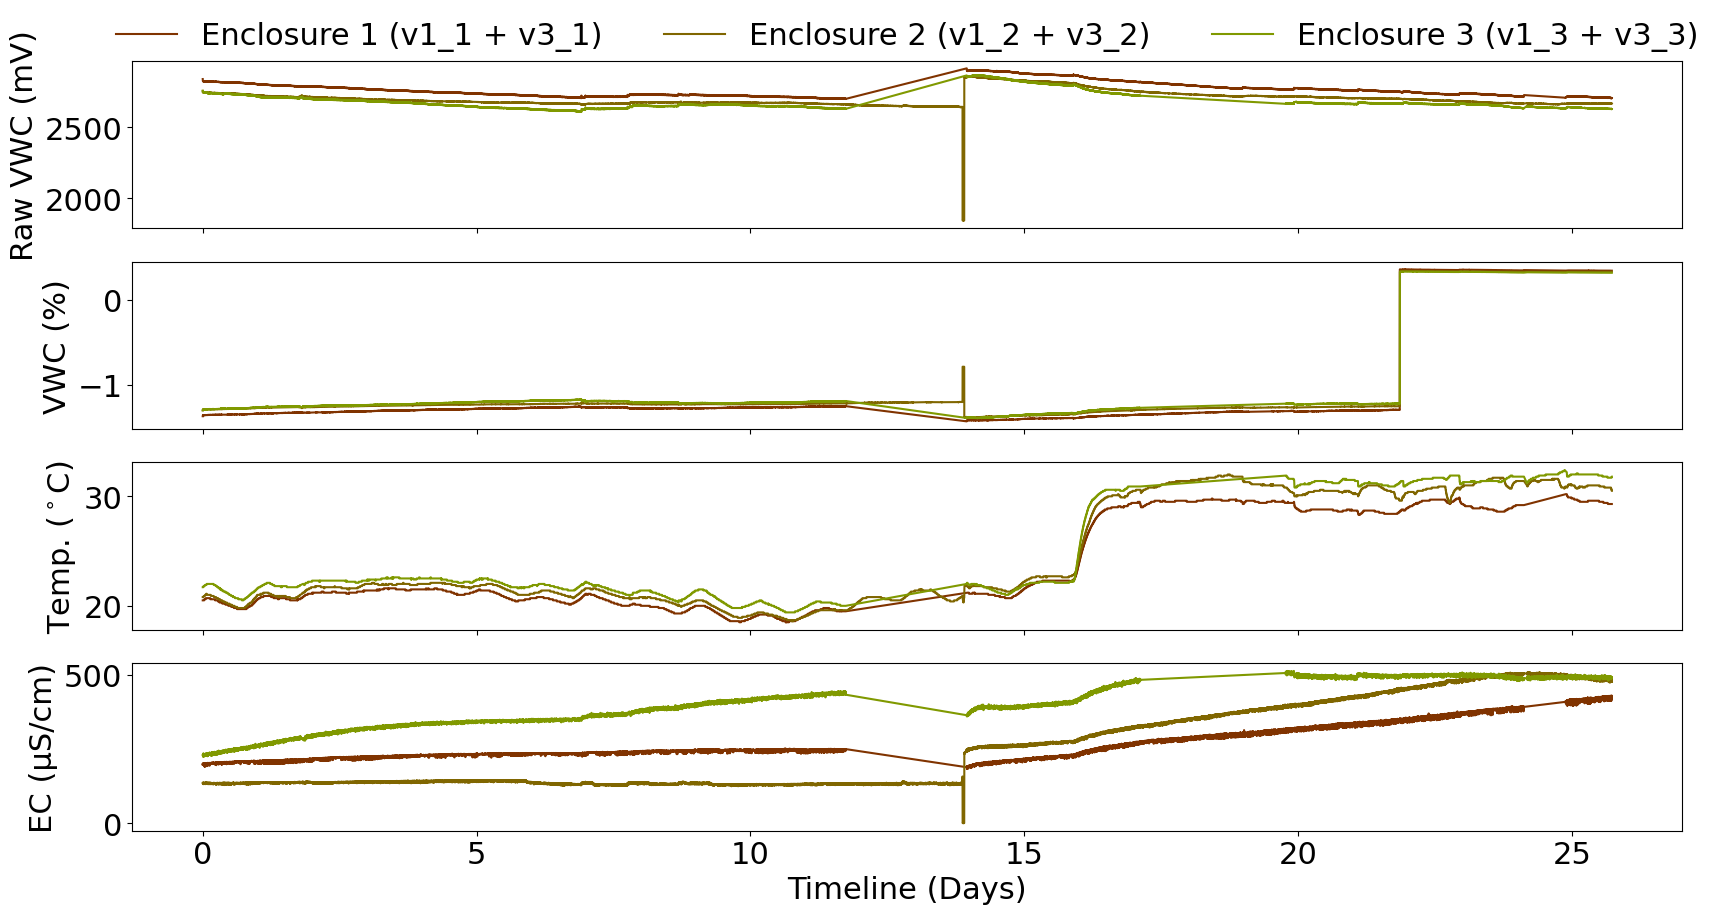

In [5]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams.update({'font.size': 22})
fig1, axs1 = plt.subplots(4)

#raw VWC (mV)
axs1[0].plot(teros[0]['ts'], teros[0]['raw_vwc'], label="Enclosure 1 (v1_1 + v3_1)", color= (0.5,0.2,0))
#axs1[0].plot(teros[3]['ts'], teros[3]['raw_vwc'], label="v3_1", color= (0,0.2,0.5))

axs1[0].plot(teros[1]['ts'], teros[1]['raw_vwc'], label="Enclosure 2 (v1_2 + v3_2)", color= (0.5,0.4,0))
#axs1[0].plot(teros[4]['ts'], teros[4]['raw_vwc'], label="v3_2", color= (0,0.4,0.5))

axs1[0].plot(teros[2]['ts'], teros[2]['raw_vwc'], label="Enclosure 3 (v1_3 + v3_3)", color= (0.5,0.6,0))
#axs1[0].plot(teros[5]['ts'], teros[5]['raw_vwc'], label="v3_3", color= (0,0.6,0.5))

axs1[0].xaxis.set_tick_params(labelbottom=False) 

#VWC (%)
axs1[1].plot(teros[0]['ts'], teros[0]['vwc'], label="Enclosure 1 (v1_1 + v3_1)", color= (0.5,0.2,0))
#axs1[1].plot(teros[3]['ts'], teros[3]['vwc'], label="v3_1", color= (0,0.2,0.5))

axs1[1].plot(teros[1]['ts'], teros[1]['vwc'], label="Enclosure 2 (v1_2 + v3_2)", color= (0.5,0.4,0))
#axs1[1].plot(teros[4]['ts'], teros[4]['vwc'], label="v3_2", color= (0,0.4,0.5))

axs1[1].plot(teros[2]['ts'], teros[2]['vwc'], label="Enclosure 3 (v1_3 + v3_3)", color= (0.5,0.6,0))
#axs1[1].plot(teros[5]['ts'], teros[5]['vwc'], label="v3_3", color= (0,0.6,0.5))

axs1[1].xaxis.set_tick_params(labelbottom=False) 

#Temp (C)
axs1[2].plot(teros[0]['ts'], teros[0]['temp'], label="Enclosure 1 (v1_1 + v3_1)", color= (0.5,0.2,0))
#axs1[2].plot(teros[3]['ts'], teros[3]['temp'], label="v3_1", color= (0,0.2,0.5))

axs1[2].plot(teros[1]['ts'], teros[1]['temp'], label="Enclosure 2 (v1_2 + v3_2)", color= (0.5,0.4,0))
#axs1[2].plot(teros[4]['ts'], teros[4]['temp'], label="v3_2", color= (0,0.4,0.5))

axs1[2].plot(teros[2]['ts'], teros[2]['temp'], label="Enclosure 3 (v1_3 + v3_3)", color= (0.5,0.6,0))
#axs1[2].plot(teros[5]['ts'], teros[5]['temp'], label="v3_3", color= (0,0.6,0.5))

axs1[2].xaxis.set_tick_params(labelbottom=False) 

#EC (µS/cm)
axs1[3].plot(teros[0]['ts'], teros[0]['ec'], label="Enclosure 1 (v1_1 + v3_1)", color= (0.5,0.2,0))
#axs1[3].plot(teros[3]['ts'], teros[3]['ec'], label="v3_1", color= (0,0.2,0.5))

axs1[3].plot(teros[1]['ts'], teros[1]['ec'], label="Enclosure 2 (v1_2 + v3_2)", color= (0.5,0.4,0))
#axs1[3].plot(teros[4]['ts'], teros[4]['ec'], label="v3_2", color= (0,0.4,0.5))

axs1[3].plot(teros[2]['ts'], teros[2]['ec'], label="Enclosure 3 (v1_3 + v3_3)", color= (0.5,0.6,0))
#axs1[3].plot(teros[5]['ts'], teros[5]['ec'], label="v3_3", color= (0,0.6,0.5))

# for ax in axs.flat:
#     ax.set(xlabel='x-label', ylabel='y-label')
axs1[0].set_ylabel('Raw VWC (mV)')
axs1[1].set_ylabel('VWC (%)')
axs1[2].set_ylabel('Temp. ($^\circ$C)')
axs1[3].set_ylabel('EC (µS/cm)')
plt.xlabel('Timeline (Days)')

plt.legend(loc='upper center', bbox_to_anchor=(0.5,5),
          fancybox=True, ncol=3, frameon=False)
plt.show()